
### Examining racial discrimination in the US job market

#### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

#### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes.

#### Exercise
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value.
   4. Discuss statistical significance.

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [3]:
# number of callbacks for balck-sounding names
sum(data[data.race=='b'].call)

157.0

***1. What test is appropriate for this problem? Does CLT apply?***

In reality there are a variety of ways we could approach this problem, using both parametric and non-parametric tests.
A traditional approach would be to test the difference in sample proportions using a z-test, for which we need the following assumptions:
    
1. Simple random sampling
2. Independent samples
3. np and n(1-p) > 10
4. Populations 20x greater than samples

In [4]:
# Proportion of callbacks in whole population
n = len(data)
p = sum(data.call)/len(data)
print("np is {:,.0f} and n(1-p) is {:,.0f}".format(n*p, n*(1-p)))

np is 392 and n(1-p) is 4,478


Looking at the required assumptions:
    
1. The researchers state that they randomly assigned names to curriculums
2. The methodology also seems to cover independence criteria
3. Using the estimated population proportion, we can see that both np and n(1-p) > 10
4. The real jobseeker population is clearly far larger than either of the samples

***2. What are the null and alternate hypotheses?***

- H0: Equal callback rate between white/black (p-white = p-black)
- H1: Callback rate not equal between white/black (p-white != p-black)

[Note: the alternative hypothesis could also be white callback rate > black callback rate, depending on how the research question is phrased. In this case, the stated aim seems to be to determine 'the impact' of race on requests for interviews and so I feel the right approach is to use a 2-tailed test]

***3. Compute margin of error, confidence interval, and p-value.***

In [5]:
# Calculate margin of error 
n_white = len(data[data.race == 'w'])
n_black = len(data[data.race == 'b'])

p_white = sum(data[data.race == 'w'].call) / n_white
p_black = sum(data[data.race == 'b'].call) / n_black

se = np.sqrt(((p_white + (1 - p_white))/n_white) + ((p_black + (1 - p_black))/n_black))

critical_prob = (1 - 0.05/2)
critical_val = stats.norm.cdf(critical_prob)

margin_of_error = critical_val * se

print("Margin of Error is {}".format(margin_of_error))

Margin of Error is 0.0239368133185817


In [6]:
# 95% confidence interval
lower = (p_white - p_black) - margin_of_error
upper = (p_white - p_black) + margin_of_error
print("95% confidence interval for difference of callback rates is [{:.5f}, {:.5f}]".format(lower, upper))

95% confidence interval for difference of callback rates is [0.00810, 0.05597]


In [7]:
# Hypothesis test
# Calculate the Z statistic
se = np.sqrt(p*(1 - p)*(1/n_white + 1/n_black))

z = (p_white - p_black) / se

# Calculate the p-value
p = 2 * stats.norm.cdf(-1*z)

print("z statistic = {:.3f}, p value = {}".format(z, p))

z statistic = 4.108, p value = 3.983886837585077e-05


In [8]:
# We can look at this another way by looking at the critical values for 0.05
stats.norm.ppf(0.025)

-1.9599639845400545

That is there is a 95% chance that a randomly chosen z-statistic falls between [-1.96, +1.96], and so clearly our z-statistic of 4.108 falls far outside this range

##### Additional work

One thing (and perhaps the most important thing) we have not looked at so far is the actual effect size. One way to look at this is using the odds ratio:

In [9]:
odds = (p_white*(1-p_white))/(p_black*(1-p_black))
print("Odds ratio is {:.3f}".format(odds))

Odds ratio is 1.446


What this means is that for a resume with a white-sounding name, the odds of being invited for interview are 1.4 times the odds for a resume with a black-sounding name.

Additionally, we can easily approach this problem using non-parametric methods such as resampling. These have the benefit of requiring far fewer underlying assumptions than parametric tests, for example typically only requiring the samples to be random and representative.

For example, we can use bootstrapping to create a confidence interval:

In [10]:
def resample(gp1, gp2):
    """
    Resamples with replacement from two lists or arrays
    
    :params gp1, gp2: lists or arrays of values
    :return: new arrays of equal length to inputs
    """
    group1 = np.random.choice(gp1, len(gp1), replace=True)
    group2 = np.random.choice(gp2, len(gp2), replace=True)
    return group1, group2

def calculate_difference(groups):
    """
    Calculate the test statistic in question: the difference in proportions between two groups.
    
    :params groups: tuple of lists or arrays
    :return: float
    """
    prop_1 = sum(groups[0])/len(groups[0])
    prop_2 = sum(groups[1])/len(groups[1])
    return prop_1 - prop_2

def calculate_statistics(gp1, gp2, iters=1000):
    """
    Runs the bootstrapping procedure a specified number of times and calculates the difference in
    proportions for each iteration.
    
    :params gp1, gp2: lists or arrays of values
    :params iters: number of iterations to run
    :return: array of test statistics of length iters
    """
    stats = [calculate_difference(resample(gp1, gp2)) for i in range(iters)]
    return np.array(stats)

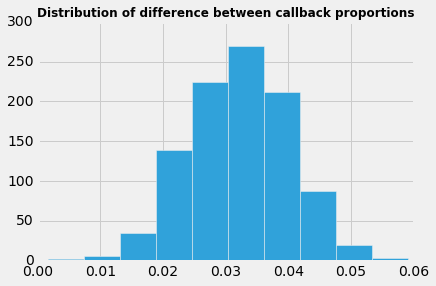

SE 0.00801693197824
95% Confidence Interval [ 0.0164271   0.04723819]


In [11]:
white = np.array(data[data['race'] == 'w']['call'])
black = np.array(data[data['race'] == 'b']['call'])

sample_stats = calculate_statistics(white, black)
plt.style.use('fivethirtyeight')
plt.hist(sample_stats, bins=10)
plt.title('Distribution of difference between callback proportions', size=12, weight='bold')
plt.show()
print('SE', sample_stats.std())
print('95% Confidence Interval', np.percentile(sample_stats, [2.5, 97.5]))

Similarly we can use permutations for hypothesis testing:

In [12]:
def permute(pool,n):
    """
    Permutes a list or array and returns the suffled list split into two sub-lists of size n and len(pool) - n
    
    :params pool: list or array
    :params n: length of first required subset
    :return: tuple of lists or arrays
    """
    np.random.shuffle(pool)
    data = pool[:n], pool[n:]
    return data

def calculate_test_statistic(pool, n, iters=1000):
    """
    Runs the bpermutation procedure a specified number of times and calculates the difference in
    proportions for each iteration.
    
    :params pool: list or array of values
    :params n: length of first sample to simulate
    :params iters: number of iterations to run
    :return: array of test statistics of length iters
    """
    stats = [calculate_difference(permute(pool, n)) for i in range(iters)]
    return np.array(stats)

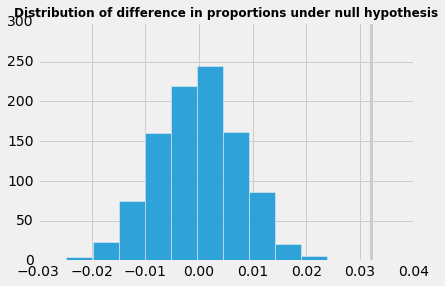

In [13]:
observed_diff = p_white - p_black
sample_size = len(data[data['race'] == 'w'])
pool = list(data[data['race'] == 'w']['call']) + list(data[data['race'] == 'b']['call'])
test_stats = calculate_test_statistic(pool, sample_size)

plt.hist(test_stats)
plt.title('Distribution of difference in proportions under null hypothesis', size=12, weight='bold')
plt.vlines(observed_diff, 0, 300, linewidth=3, color='0.8')
plt.show()

One nice thing about this method is that it gives us a complete distribution for the statistic under the Null hypothesis. Here for example we can see that the actual observed difference (line in grey) falls far outside of what we would expect under the null hypothesis

In [14]:
pvalue = sum(test_stats >= observed_diff) / len(test_stats)
print("p-value is {}".format(pvalue))

p-value is 0.0


***4. Discuss statistical significance and conclusions. ***

However you look at it, all of our tests are in close agreement with each other.

Our two methdologies give us a 95% confidence interval of [0.00810, 0.05597] and [0.01683778  0.04681725] respectively, i.e. the proportion of callbacks for white-sounding names is always positive.

Furthermore, for our hypothesis test for a null hypothesis of equal proportions, we get a p-value of not just less than 0.05, but in fact less than 0.0001.
While one must be wary of p-values, in this case at least based on order of magnitude, I think we can be quite confident of rejecting the null hypothesis.
